In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import Counter


In [144]:
files = os.listdir('predictions')
print(files)

['predictions_seed1_Diffusion_bool_ABC_25epoch.csv', 'predictions_seed3_Diffusion_bool_B_25epoch.csv', 'predictions_seed1_Diffusion_bool_ABCD_25epoch.csv', 'predictions_seed2_Diffusion_bool_mofkey_25epoch.csv', 'predictions_seed3_Diffusion_bool_mofkey_25epoch.csv', 'predictions_seed2_Diffusion_bool_B_25epoch.csv', 'predictions_seed2_Diffusion_bool_mofid_25epoch.csv', 'predictions_seed2_Diffusion_bool_ABCD_25epoch.csv', 'predictions_seed1_Diffusion_bool_mofkey_25epoch.csv', 'predictions_seed3_Diffusion_bool_AB_25epoch.csv', 'predictions_seed1_Diffusion_bool_A_25epoch.csv', 'predictions_seed2_Diffusion_bool_AB_25epoch.csv', 'predictions_seed1_Diffusion_bool_mofid_25epoch.csv', 'predictions_seed1_Diffusion_bool_AB_25epoch.csv', 'predictions_seed3_Diffusion_bool_A_25epoch.csv', 'predictions_seed2_Diffusion_bool_A_25epoch.csv', 'predictions_seed1_Diffusion_bool_B_25epoch.csv', 'predictions_seed2_Diffusion_bool_ABC_25epoch.csv', 'predictions_seed3_Diffusion_bool_ABCD_25epoch.csv', 'predictio

In [145]:
def create_csv_df(folder):
    files = os.listdir(folder)
    files_path = [os.path.join(folder, i) for i in files]
    df = pd.DataFrame({'file':files_path})
    df['representation'] = [i.split('_bool_')[-1].split('_')[0] for i in files]
    df['seed'] = [i.split('_seed')[-1].split('_')[0] for i in files]
    df = df.sort_values(['seed', 'representation'])


    return df

csv_df = create_csv_df('predictions') 

In [166]:
def calculate_accuracy(actual_labels, predicted_labels, rounding = 1):
    """
    Calculate accuracy manually without using sklearn.
    
    Parameters:
        actual_labels (list): List of actual labels.
        predicted_labels (list): List of predicted labels.
        
    Returns:
        float: Accuracy percentage.
    """
    if len(actual_labels) != len(predicted_labels):
        raise ValueError("Length of actual_labels and predicted_labels must be the same.")
    
    correct = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total = len(actual_labels)
    accuracy = correct / total * 100
    accuracy = round(accuracy, rounding)
    return accuracy

def most_frequent(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num

def get_csvs_seed(df, seed):
    return df.loc[df['seed'] == str(seed)]

def create_seed_overview(csv_df, seed):
    seed_df = get_csvs_seed(csv_df, seed)
    print(f'Analyzing seed {seed}. ({len(seed_df)} files)')
    for i, (_, row) in enumerate(seed_df.iterrows()):
        pred_df = pd.read_csv(row['file'])
        repres = list(pred_df.columns)[1]

        test_df = pred_df.loc[pred_df['partition'] == 'test']
        if i == 0:
            overview_df = pd.DataFrame({'structure': test_df['Unnamed: 0'],
                                        'true': test_df['Diffusion_bool']})
        
        overview_df[f'{repres}_pred'] = test_df['prediction']

    return overview_df

def analyse_seed(df:pd.DataFrame):
    perc_0, perc_1 = [], []
    for _, row in df.iterrows():
        pred_cols = [col for col in df.columns if col.endswith('_pred')]
        values = [row[col] for col in pred_cols]
        perc_0.append(values.count(0)/len(values))
        perc_1.append(values.count(1)/len(values))

    df['perc_0'] = perc_0
    df['perc_1'] = perc_1
    df['pred_same'] = [p in [0,1] for p in df['perc_0']]

    n_same = list(df['pred_same']).count(True)
    df_same_pred = df.loc[df['pred_same'] == True]
    df['pred_same_correct'] = [same == True and true == pred for same, true, pred in zip(df['pred_same'], df['true'], df[pred_cols[0]])]
    print(f'For {len(df_same_pred)} entries ({100 * (len(df_same_pred)/len(df))} %), all the {len(pred_cols)} predictions were the same')
    n_same_correct = list(df['pred_same_correct']).count(True)
    print(f'For these {len(df_same_pred)} predictions, {n_same_correct} were CORRECT')
    return df

def plot_analysis(df:pd.DataFrame):
    fig, ax = plt.subplots(1,1, figsize = (10, 10), tight_layout = True, sharex=True,
                           )
    color_map = 'Blues'

    

    df['agreementPerc'] = [round(max([i,j]), 2) for i,j in zip(df['perc_0'], df['perc_1'])]
    df['agreementToTrue'] = [round(data[f'perc_{true}'],2) for true, (i, data) in zip(df['true'], df.iterrows())]
    
    pred_cols = [col for col in df.columns if col.endswith('_pred')]

    pred_col2 = ['true'] + pred_cols
    df_pred = df[pred_col2]
    accuracies = {col: calculate_accuracy(list(df_pred['true']), list(df_pred[col])) for col in pred_cols}
    print(accuracies)

    majority_vote = []
    majority_vote_weight = []
    for i, row in df.iterrows():
        votes = []
        votes_weight = []
        for a in pred_cols:
            votes_weight.append(row[a] * accuracies[a])
            votes.append(row[a])
        print(votes_weight)
        majority_vote_weight.append((votes))
        majority_vote.append(most_frequent(votes))

    df_pred['Majority Vote'] = majority_vote

    for i, row in df.iterrows():
        agreement = row['agreementPerc']
        ax.text(i, 0 +10, str(agreement), fontsize=7, rotation = 90)

        agreement_to_true = row['agreementToTrue']
        ax.text(i, 0 +12, str(agreement_to_true), fontsize=7, rotation = 90)
    
    
    display_cols = ['true'] + pred_cols + ['Majority Vote']

    a = df_pred.to_numpy()
    a = np.transpose(a)
    
    ax.imshow(a, 
              cmap = color_map
              )
    ax.set_yticks(np.arange(len(display_cols)), labels=[col.split('_pred')[0] for col in display_cols])


    sames = df.index[df['pred_same'] == True].tolist()
    for same in sames:
        ax.vlines([same-0.5, same +0.5], -0.5,len(display_cols)-0.5, colors = 'green', linewidth = 5)
    ax.hlines(0.5, 0-0.5, len(df)-0.5, linewidth = 2, colors = 'maroon')
    ax.hlines(len(display_cols)-1.5, 0-0.5, len(df)-0.5, linewidth = 2, colors = 'maroon')

    n_same = dict(df['pred_same'].value_counts())[True]
    n_same_correct = dict(df['pred_same_correct'].value_counts())[True]
    ax.set_title(f'Same Predictions: {n_same} ({round(n_same/len(df) *100,2) }%)\nAccuracy Same Predictions: {n_same_correct} ({round(n_same_correct/n_same *100,2) }%)')
    
    ax.text(len(df) + 0.25, -0.5, 'Acc.', fontsize=10)

    accuracies = {}
    for i, col in enumerate(pred_cols + ['Majority Vote']):
        accuracy = calculate_accuracy(list(df_pred['true']), list(df_pred[col]))
        accuracies.update({col:accuracy})
        ax.text(len(df) + 0.25, i +1.5, str(accuracy), fontsize=10)
        
    

    average_Agreemetn = df['agreementPerc'].mean()
    average_Agreemetn2= df['agreementToTrue'].mean()

    majority_vote = []
    for i, row in df.iterrows():
        agreement = row['agreementPerc']
        ax.text(i, 0 +10, str(agreement), fontsize=7, rotation = 90)

        agreement_to_true = row['agreementToTrue']
        ax.text(i, 0 +12, str(agreement_to_true), fontsize=7, rotation = 90)

        votes = []
        for a in pred_cols:
            votes.append(row[a])
        #print(votes)
        #print(most_frequent(votes))
        majority_vote.append(most_frequent(votes))
        

    ax.text(i-55, 0 +10, 'Agreement of \nPredictions', fontsize=7)
    ax.text(i-55, 0 +12, 'Agreement to \nTrue', fontsize=7)

    df['majority_vote'] = majority_vote

    majority_vote_accurcy = calculate_accuracy(df['true'] , df['majority_vote'])
    print(majority_vote_accurcy)


    return df



Analyzing seed 1. (7 files)
For 7 entries (14.000000000000002 %), all the 7 predictions were the same
For these 7 predictions, 7 were CORRECT
{'A_pred': 70.0, 'AB_pred': 70.0, 'ABC_pred': 74.0, 'ABCD_pred': 72.0, 'B_pred': 70.0, 'mofid_pred': 48.0, 'mofkey_pred': 60.0}
[70.0, 0.0, 0.0, 72.0, 70.0, 48.0, 60.0]
[0.0, 70.0, 0.0, 0.0, 70.0, 0.0, 60.0]
[0.0, 70.0, 0.0, 0.0, 70.0, 0.0, 60.0]
[0.0, 0.0, 0.0, 0.0, 70.0, 48.0, 60.0]
[0.0, 0.0, 74.0, 72.0, 70.0, 0.0, 0.0]
[0.0, 0.0, 74.0, 72.0, 70.0, 0.0, 0.0]
[70.0, 70.0, 74.0, 72.0, 70.0, 0.0, 0.0]
[0.0, 0.0, 74.0, 72.0, 70.0, 48.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 0.0]
[0.0, 70.0, 74.0, 72.0, 70.0, 48.0, 0.0]
[70.0, 0.0, 0.0, 72.0, 0.0, 0.0, 0.0]
[0.0, 70.0, 74.0, 72.0, 70.0, 48.0, 60.0]
[0.0, 0.0, 0.0, 72.0, 70.0, 0.0, 60.0]
[70.0, 70.0, 74.0, 72.0, 70.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 70.0, 0.0, 60.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 60.0]
[0.0, 70.0, 0.0, 72.0, 70.0, 0.0, 0.0]
[0.0, 70.0, 74.0, 72.0, 70.0, 48.0, 0.0]
[70.0, 0.0, 74.0, 7

/tmp/ipykernel_1971361/428598950.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['Majority Vote'] = majority_vote


78.0
Analyzing seed 2. (7 files)
For 5 entries (10.0 %), all the 7 predictions were the same
For these 5 predictions, 5 were CORRECT
{'A_pred': 62.0, 'AB_pred': 82.0, 'ABC_pred': 78.0, 'ABCD_pred': 74.0, 'B_pred': 80.0, 'mofid_pred': 44.0, 'mofkey_pred': 60.0}
[0.0, 0.0, 78.0, 74.0, 80.0, 44.0, 0.0]
[0.0, 0.0, 0.0, 74.0, 80.0, 0.0, 60.0]
[0.0, 82.0, 78.0, 74.0, 80.0, 44.0, 0.0]
[62.0, 82.0, 78.0, 74.0, 80.0, 44.0, 60.0]
[62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 80.0, 0.0, 0.0]
[62.0, 0.0, 0.0, 74.0, 80.0, 44.0, 60.0]
[0.0, 0.0, 0.0, 74.0, 80.0, 0.0, 0.0]
[0.0, 82.0, 0.0, 0.0, 80.0, 44.0, 60.0]
[62.0, 82.0, 78.0, 74.0, 80.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 80.0, 44.0, 0.0]
[62.0, 82.0, 78.0, 74.0, 80.0, 44.0, 0.0]
[0.0, 82.0, 0.0, 0.0, 80.0, 0.0, 60.0]
[0.0, 82.0, 78.0, 74.0, 80.0, 0.0, 60.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 60.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 60.0]
[0.0, 0.0, 78.0, 74.0, 80.0, 44.0,

/tmp/ipykernel_1971361/428598950.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['Majority Vote'] = majority_vote
/tmp/ipykernel_1971361/428598950.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['Majority Vote'] = majority_vote


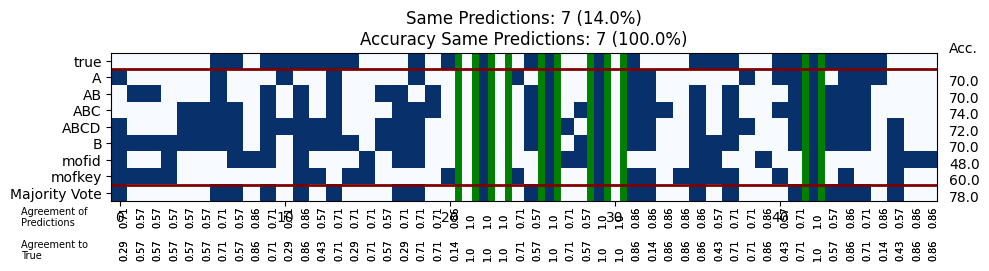

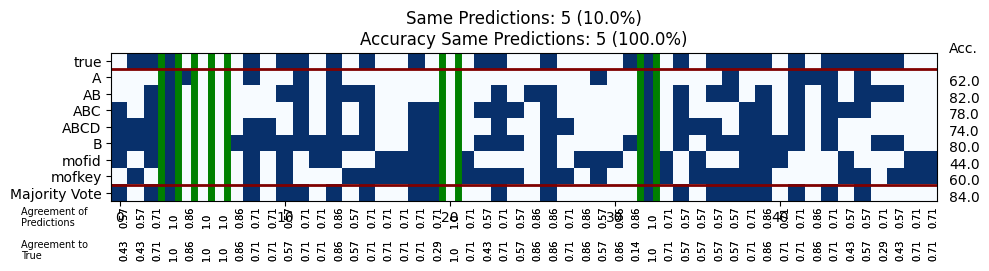

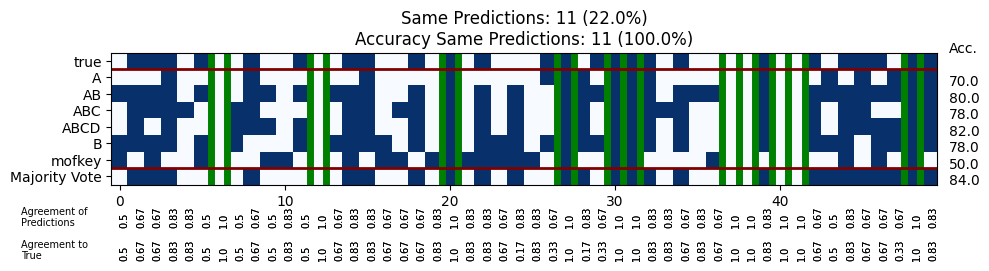

In [167]:
for seed in [1,2, 3]:
    df = create_seed_overview(csv_df, seed)
    df = analyse_seed(df)
    df.reset_index(drop=True, inplace=True)
    df_plot = plot_analysis(df)
    

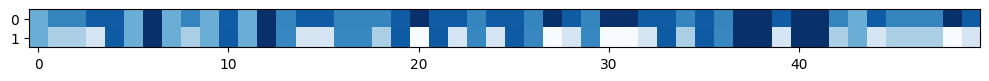

In [ ]:
df_plot['agreementPerc'] = [round(max([i,j]), 2) for i,j in zip(df_plot['perc_0'], df_plot['perc_1'])]
fig, ax = plt.subplots(1,1, figsize = (10, 10), tight_layout = True, sharex=True,
                           )
a = df[['agreementPerc', 'perc_0']].to_numpy()
a = np.transpose(a)
#print(a)
color_map = 'Blues'
ax.imshow(a, 
            cmap = color_map
              )

In [ ]:
df_plot

,structure,true,A_pred,AB_pred,ABC_pred,ABCD_pred,B_pred,mofkey_pred,perc_0,perc_1,pred_same,pred_same_correct,agreementPerc,agreementToTrue
0,438,0,0,1,0,0,1,1,0.500000,0.500000,False,False,0.50,0 0.500000 1 0.333333 2 0.333333 3...
1,1658,1,0,1,1,1,1,0,0.333333,0.666667,False,False,0.67,0 0.500000 1 0.666667 2 0.666667 3...
2,1759,1,0,1,1,0,1,1,0.333333,0.666667,False,False,0.67,0 0.500000 1 0.666667 2 0.666667 3...
3,4161,1,1,1,1,1,1,0,0.166667,0.833333,False,False,0.83,0 0.500000 1 0.666667 2 0.666667 3...
4,2098,0,0,0,1,0,0,0,0.833333,0.166667,False,False,0.83,0 0.500000 1 0.333333 2 0.333333 3...
5,3758,1,0,1,0,0,1,1,0.500000,0.500000,False,False,0.50,0 0.500000 1 0.666667 2 0.666667 3...
6,1218,0,0,0,0,0,0,0,1.000000,0.000000,True,True,1.00,0 0.500000 1 0.333333 2 0.333333 3...
7,538,0,0,0,1,1,1,0,0.500000,0.500000,False,False,0.50,0 0.500000 1 0.333333 2 0.333333 3...
8,2389,1,1,1,1,1,0,0,0.333333,0.666667,False,False,0.67,0 0.500000 1 0.666667 2 0.666667 3...
9,2871,0,0,1,0,1,0,1,0.500000,0.500000,False,False,0.50,0 0.500000 1 0.333333 2 0.333333 3...
